# Plotting code for CS267 IRL project

In [53]:
%matplotlib inline

import os.path as osp

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

# change context="paper" for final report
sns.set(context="paper", style="darkgrid")

## Plots for small-scale neural network training

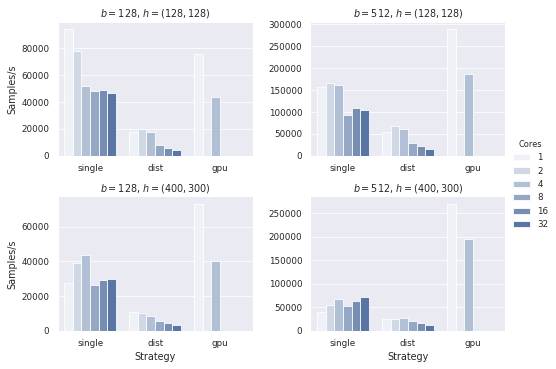

In [54]:
small_data = pd.read_csv("./small-expts/all.csv")
small_data["group"] = small_data["type"]
has_gpu = small_data["gpus"] > 0
small_data.loc[has_gpu, "group"] = "gpu"

grid = sns.FacetGrid(small_data, col="batch_size", row="hiddens",
                    sharex=False, sharey=False, height=2.5,
                     legend_out=True, aspect=1.4) \
  .map_dataframe(sns.barplot, x="group", hue="cores", y="samples_per_s") \
  .set_axis_labels("Strategy", "Samples/s") \
  .set_titles("$b={col_name}$, $h=({row_name})$") \
  .add_legend(title="Cores")
plt.savefig(osp.expanduser('~/small-expts-plot.pdf'))
plt.show()

## Plots for training sample throughput

Run 41, 16 workers, 1 gpus
Run 39, 1 workers, 0 gpus
Run 40, 16 workers, 0 gpus


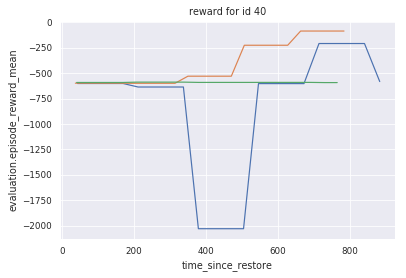

/home/sam/.virtualenvs/ray-irl/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/sam/.virtualenvs/ray-irl/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


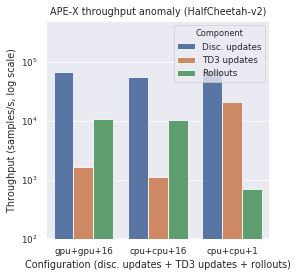

In [94]:
def add_nested_column(data, column, key):
    def add_col(cell):
        d = yaml.safe_load(cell)
        return d[key]
    data[column + "." + key] = data[column].map(add_col)

def add_delta_column(data, column):
    data["delta_" + column] = data[column].diff()

def plot_expt(expt_id):
    config = yaml.safe_load(open("./data/sacred-runs/%d/config.json" % expt_id, "r"))
    print("Run %d, %d workers, %d gpus" % (expt_id, config["td3_conf"]["num_workers"], config["tf_configs"]["discrim"]["gpu_num"] is not None))
    data = pd.read_csv("./data/sacred-runs/%d/progress.csv" % expt_id)
    add_nested_column(data, "info", "num_steps_trained")
    add_nested_column(data, "info", "num_steps_sampled")
    add_nested_column(data, "evaluation", "episode_reward_mean")
    add_delta_column(data, "disc_samples_seen")
    add_delta_column(data, "info.num_steps_trained")
    add_delta_column(data,"info.num_steps_sampled")
    add_delta_column(data, "time_since_restore")
    data['throughput_train_disc'] = data['delta_disc_samples_seen'] / data['delta_time_since_restore']
    data['throughput_train_td3'] = data['delta_info.num_steps_trained'] / data['delta_time_since_restore']
    data['throughput_rollouts'] = data['delta_info.num_steps_sampled'] / data['delta_time_since_restore']
    # sns.lineplot(x=data["time_since_restore"], y=data["throughput_train_disc"], label='Disc. train')
    # sns.lineplot(x=data["time_since_restore"], y=data["throughput_train_td3"], label='TD3 train')
    # sns.lineplot(x=data["time_since_restore"], y=data["throughput_rollouts"], label='Rollouts')
    # plt.title("throughput for id %d" % expt_id)
    # plt.yscale("log")
    # plt.ylabel("Samples/s")
    # plt.xlabel("Time (s)")
    # plt.show()
    plt.title("reward for id %d" % expt_id)
    sns.lineplot(data=data, x="time_since_restore", y="evaluation.episode_reward_mean")
    # Average throughput steps over the last five epochs.
    return np.mean(list(data["throughput_train_disc"])[-10:]), np.mean(list(data["throughput_train_td3"])[-10:]), np.mean(list(data["throughput_rollouts"])[-10:])

def do_hacky_throughput(full_num, rest_num, nogpu_num, title):
    full_tp_disc, full_tp_train, full_tp_roll = plot_expt(full_num)
    rest_tp_disc, rest_tp_train, rest_tp_roll = plot_expt(rest_num)
    nogpu_tp_disc, nogpu_tp_train, nogpu_tp_roll = plot_expt(nogpu_num)
    plt.show()
    records = [
        {
            'type': 'gpu+gpu+16',
            'Component': 'Disc. updates',
            'throughput': full_tp_disc,
        },
        {
            'type': 'gpu+gpu+16',
            'Component': 'TD3 updates',
            'throughput': full_tp_train,
        },
        {
            'type': 'gpu+gpu+16',
            'Component': 'Rollouts',
            'throughput': full_tp_roll,
        },
        {
            'type': 'cpu+cpu+16',
            'Component': 'Disc. updates',
            'throughput': nogpu_tp_disc,
        },
        {
            'type': 'cpu+cpu+16',
            'Component': 'TD3 updates',
            'throughput': nogpu_tp_train,
        },
        {
            'type': 'cpu+cpu+16',
            'Component': 'Rollouts',
            'throughput': nogpu_tp_roll,
        },
        {
            'type': 'cpu+cpu+1',
            'Component': 'Disc. updates',
            'throughput': rest_tp_disc,
        },
        {
            'type': 'cpu+cpu+1',
            'Component': 'TD3 updates',
            'throughput': rest_tp_train,
        },
        {
            'type': 'cpu+cpu+1',
            'Component': 'Rollouts',
            'throughput': rest_tp_roll,
        },
    ]
    plt.figure(figsize=(4, 4))
    rec_data = pd.DataFrame.from_records(records)
    sns.barplot(data=rec_data, y='throughput', hue='Component', x='type')
    plt.title(title)
    plt.ylabel("Throughput (samples/s, log scale)")
    plt.xlabel("Configuration (disc. updates + TD3 updates + rollouts)")
    plt.ylim(ymin=100, ymax=5e5)
    plt.yscale("log")

do_hacky_throughput(41, 39, 40, "APE-X throughput anomaly (HalfCheetah-v2)")
plt.savefig(osp.expanduser("~/halfcheetah-results-buggy.pdf"))
plt.show()

Another one with the fixed code:

Run 44, 16 workers, 1 gpus
Run 42, 1 workers, 0 gpus
Run 43, 16 workers, 0 gpus


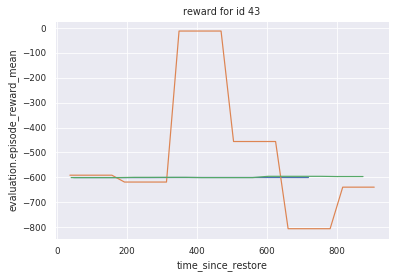

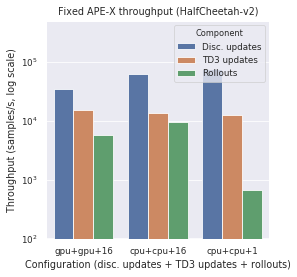

In [95]:
do_hacky_throughput(44, 42, 43, "Fixed APE-X throughput (HalfCheetah-v2)")
plt.savefig(osp.expanduser("~/halfcheetah-results-nobugs.pdf"))
plt.show()

## Loss plots & final throughput plots

Label for run 51 is gpu+gpu+16
Label for run 52 is cpu+cpu+1
Label for run 53 is cpu+cpu+16
Label for run 54 is gpu+gpu+16
Label for run 55 is cpu+cpu+1
Label for run 56 is cpu+cpu+16
Label for run 57 is gpu+gpu+16
Label for run 58 is cpu+cpu+1
Label for run 59 is cpu+cpu+16
Label for run 60 is gpu+gpu+16
Label for run 61 is cpu+cpu+1
Label for run 62 is cpu+cpu+16
Label for run 63 is cpu
Label for run 64 is cpu
Label for run 65 is cpu
Label for run 66 is cpu


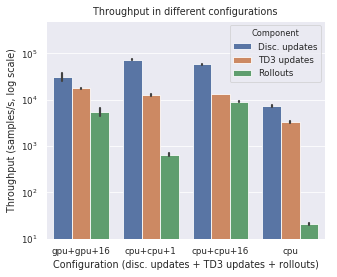

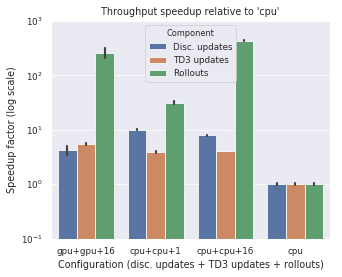

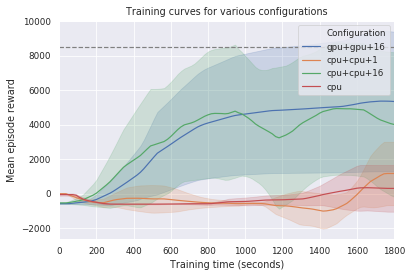

In [151]:
def process_run(run_id, min_time=0.0, max_time=1800.0):
    """Do throughput calculations The Right Way(tm), by averaging
    number of samples processed over total running time. The above
    code doesn't do that; instead, it averages throughput only over
    the last few steps b/c it was trying to avoid initialisation
    effects on short runs. The approach in this function makes more
    sense for long runs.
    
    This function also computes labels automatically, instead of
    relying on me to do it :)"""
    with open("./data/sacred-runs/%d/config.json" % run_id) as fp:
        config = yaml.safe_load(fp)
    sync_run = config.get('sync_coord', False)
    rollout_workers = config['td3_conf']['num_workers']
    if sync_run:
        if rollout_workers > 0:
            label = 'cpu (%d)' % rollout_workers
        else:
            label = 'cpu'
    else:
        disc_worker_type = ['cpu', 'gpu'][config['tf_configs']['discrim']['gpu_num'] is not None]
        td3_worker_type = ['cpu', 'gpu'][config['tf_configs']['td3_remote_learner']['gpu_num'] is not None]
        label = "%s+%s+%s" % (disc_worker_type, td3_worker_type, rollout_workers)
    print("Label for run %d is" % run_id, label)
    data = pd.read_csv("./data/sacred-runs/%d/progress.csv" % run_id)
    add_nested_column(data, "info", "num_steps_trained")
    add_nested_column(data, "info", "num_steps_sampled")
    add_nested_column(data, "evaluation", "episode_reward_mean")
    # throughput figures
    data["throughput_td3"] = data["info.num_steps_trained"] / data["time_since_restore"]
    data["throughput_rollout_disc"] = data["info.num_steps_sampled"] / data["time_since_restore"]
    data["throughput_disc"] = data["disc_samples_seen"] / data["time_since_restore"]
    # reward dataframe; this is a simple DF showing just reward at the end of each
    # unique evaluation
    eval_rewards = data["evaluation.episode_reward_mean"]
    mask = eval_rewards.shift(1) != eval_rewards
    eval_times = data["time_since_restore"]
    eval_rewards, eval_times = eval_rewards[mask], eval_times[mask]
    # We do this silly interpolation trick so that estimates of reward at
    # each time are aligned when we do sns.lineplot. That allows seaborn
    # to draw SD or CI.
    sample_times = np.linspace(min_time, max_time, 100)
    eval_rewards = eval_rewards.to_numpy()
    smooth_eval_rewards = eval_rewards.copy()
    # moving window averaging to deal with random drops that happens when doing value-learning
    for idx in range(len(eval_rewards)):
        left = idx - 1
        left = max(left, 0)
        right = idx + 2
        window = eval_rewards[left:right]
        smooth_eval_rewards[idx] = window.mean()
    eval_times = eval_times.to_numpy()
    if label == 'cpu':
        # stupid hack to fix my dumb method of recording time
        eval_times = eval_times * 1800 / 1300
    sample_rewards = np.interp(sample_times, eval_times, smooth_eval_rewards)
    label_series = [label] * len(sample_times)
    reward_df = pd.DataFrame.from_dict({
        "Configuration": label_series,
        "time": sample_times,
        "reward": sample_rewards,
    })
    return data, reward_df, label

runs = [
    51, 52, 53,
    54, 55, 56,
    57, 58, 59,
    60, 61, 62,
    # these are all sequential runs:
    63, 64,
    65, 66
]
# Format I want for throughput dics:
# {'type': 'cpu+cpu+1', 'Component': 'Rollouts', 'throughput': rest_tp_roll},
reward_frames = []
throughput_dicts = []
tp_base_dict = {}
for run_id in runs:
    data, reward_data, label = process_run(run_id)
    component_columns = [
        ('Disc. updates', 'throughput_disc'),
        ('TD3 updates', 'throughput_td3'),
        ('Rollouts', 'throughput_rollout_disc'),
    ]
    for tpname, tpcol in component_columns:
        tpval = list(data[tpcol])[-1]
        if label == 'cpu':
            tp_base_dict.setdefault(tpname, []).append(tpval)
        throughput_dicts.append({
            'type': label,
            'Component': tpname,
            'throughput': tpval
        })
    reward_frames.append(reward_data)

for tp_dict in throughput_dicts:
    tp_base_mean = np.mean(tp_base_dict[tp_dict['Component']])
    tp_dict['throughput_rel'] = tp_dict['throughput'] / tp_base_mean

# Plot throughput
plt.figure(figsize=(5, 4))
rec_data = pd.DataFrame.from_records(throughput_dicts)
sns.barplot(data=rec_data, y='throughput', hue='Component', x='type')
plt.title("Throughput in different configurations")
plt.ylabel("Throughput (samples/s, log scale)")
plt.xlabel("Configuration (disc. updates + TD3 updates + rollouts)")
plt.ylim(ymin=10, ymax=5e5)
plt.yscale("log")
plt.savefig(osp.expanduser("~/final-tp-plots.pdf"))
plt.show()

# Throughput relative to single
plt.figure(figsize=(5, 4))
sns.barplot(data=rec_data, y='throughput_rel', hue='Component', x='type')
plt.title("Throughput speedup relative to 'cpu'")
plt.ylabel("Speedup factor (log scale)")
plt.xlabel("Configuration (disc. updates + TD3 updates + rollouts)")
plt.ylim(ymin=1e-1, ymax=1e3)
plt.yscale("log")
plt.savefig(osp.expanduser("~/final-tp-speedup.pdf"))
plt.show()

# Loss curves, with error bars (very important, as it turns out :D)
reward_df_big = pd.concat(reward_frames)
sns.lineplot(data=reward_df_big, x='time', y='reward', hue='Configuration', ci='sd')
# sns.scatterplot(data=reward_df_big, x='time', y='reward', hue='Configuration')
plt.xlim(0, 1800)
plt.ylabel("Mean episode reward")
plt.xlabel("Training time (seconds)")
plt.axhline(8500, ls='--', color='gray')
plt.title("Training curves for various configurations")
plt.savefig(osp.expanduser("~/final-loss-curves.pdf"))
plt.show()